In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import itertools
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

**Loading Dataset**

In [2]:
data_dir = '/Users/mehakklunkar/Downloads/brain_tumor/training'
tumor_types = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

class_counts = {tumor_type: len(os.listdir(os.path.join(data_dir, tumor_type))) for tumor_type in tumor_types}
print(class_counts)

{'glioma_tumor': 826, 'meningioma_tumor': 822, 'pituitary_tumor': 827, 'no_tumor': 395}


**Distribution of the Tumor Classes:**

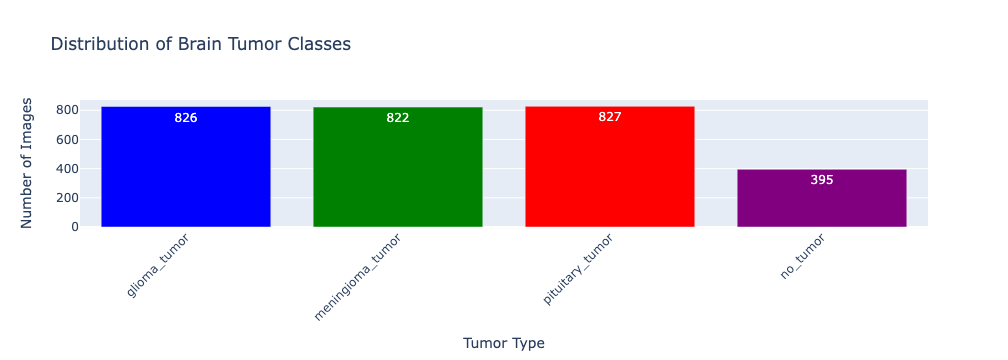

In [3]:
tumor_types = list(class_counts.keys())
counts = list(class_counts.values())

fig = go.Figure(data=[go.Bar(
    x=tumor_types,
    y=counts,
    text=counts,
    textposition='auto',
    marker_color=['blue', 'green', 'red', 'purple']
)])

fig.update_layout(
    title='Distribution of Brain Tumor Classes',
    xaxis_title='Tumor Type',
    yaxis_title='Number of Images',
    xaxis_tickangle=-45
)
fig.show()

**Train-Test Split:**

In [4]:
def load_data(data_dir):
    tumor_types = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']
    images = []
    labels = []
    
    for tumor_type in tumor_types:
        tumor_dir = os.path.join(data_dir, tumor_type)
        for img_name in os.listdir(tumor_dir):
            img_path = os.path.join(tumor_dir, img_name)
            images.append(img_path)
            labels.append(tumor_type)
    
    return images, labels

images, labels = load_data(data_dir)
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(labels)

X_train, X_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=42, stratify=y)

**Normalise Images:**

In [5]:
def load_images(image_paths, target_size=(128, 128)):
    images = []
    for path in image_paths:
        img = image.load_img(path, target_size=target_size, color_mode='grayscale')
        img_array = image.img_to_array(img)
        images.append(img_array)
    return np.array(images)


X_train = load_images(X_train) / 255.0
X_test = load_images(X_test) / 255.0

**Data Augmentation**

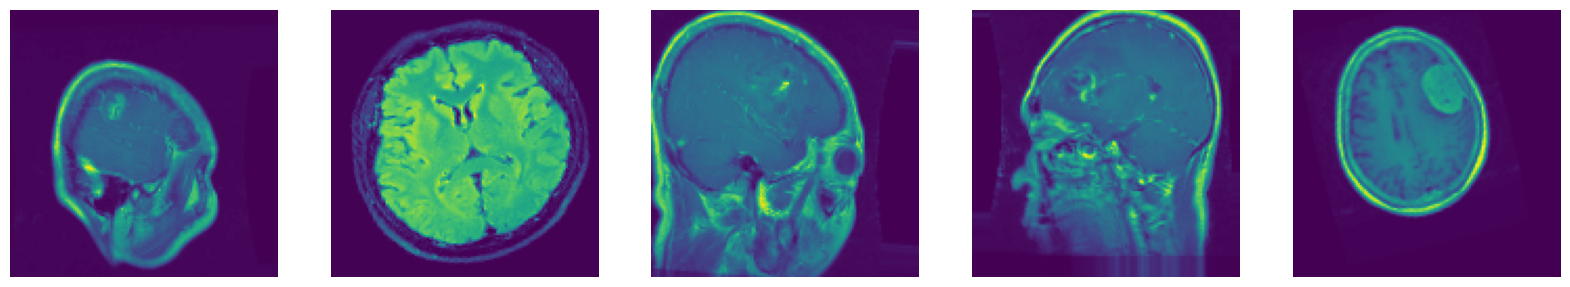

In [6]:
augmentdata = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

augmented_images = augmentdata.flow(X_train[:5], batch_size=5, shuffle=False)

augmented_batch = next(augmented_images)

fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(augmented_batch[i])
    ax[i].axis('off')
plt.show()

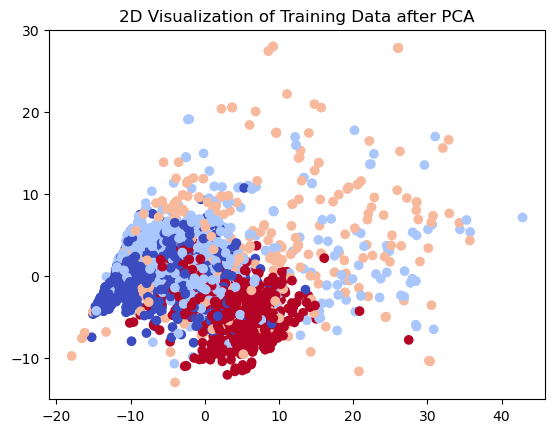

In [15]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)

svm = OneVsRestClassifier(SVC(kernel='rbf', probability=True))
svm.fit(X_train_pca, y_train)

# svm = SVC(kernel='rbf', probability=True)
# svm.fit(X_train_pca, y_train)


plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm')
plt.title('2D Visualization of Training Data after PCA')
plt.show()

**Confusion Matrix:**

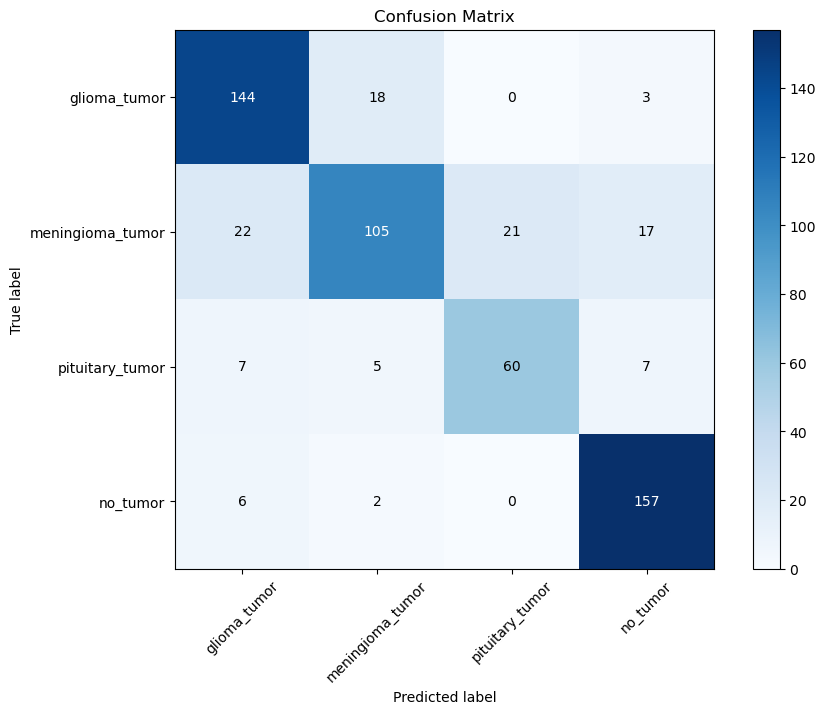

In [16]:
y_pred = svm.predict(X_test_pca)


conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(tumor_types))
plt.xticks(tick_marks, tumor_types, rotation=45)
plt.yticks(tick_marks, tumor_types)
plt.xlabel('Predicted label')
plt.ylabel('True label')

for i in range(len(tumor_types)):
    for j in range(len(tumor_types)):
        plt.text(j, i, conf_matrix[i, j],
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.show()

In [17]:
print("Training Score:", svm.score(X_train_pca, y_train))
print("Testing Score:", svm.score(X_test_pca, y_test))

Training Score: 0.9233449477351916
Testing Score: 0.8118466898954704


**Classification Report:**

In [18]:
print(classification_report(y_test, y_pred, target_names=tumor_types))

                  precision    recall  f1-score   support

    glioma_tumor       0.80      0.87      0.84       165
meningioma_tumor       0.81      0.64      0.71       165
 pituitary_tumor       0.74      0.76      0.75        79
        no_tumor       0.85      0.95      0.90       165

        accuracy                           0.81       574
       macro avg       0.80      0.81      0.80       574
    weighted avg       0.81      0.81      0.81       574



**ROC Curve:**

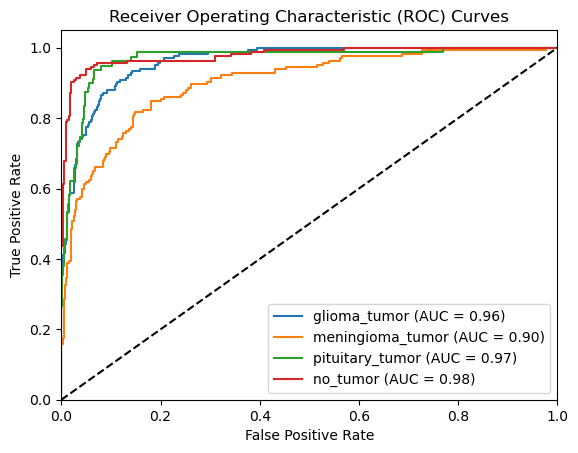

In [19]:
y_prob = svm.predict_proba(X_test_pca)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(tumor_types)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


for i in range(len(tumor_types)):
    plt.plot(fpr[i], tpr[i], label=f'{tumor_types[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()

In [20]:
param_grid = {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'degree': [2, 3, 4]}
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train_pca, y_train)

print("Best Parameters:", grid.best_params_)
y_pred_grid = grid.predict(X_test_pca)
print(classification_report(y_test, y_pred_grid, target_names=tumor_types))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   0.2s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   0.1s
[CV] END .....................C=0.1, degree=2, kernel=linear; total time=   0.1s
[CV] END ........................C=0.1, degree=2, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, degree=2, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, degree=2, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, degree=2, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, degree=2, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.1, degree=2, kernel=poly; total time=   0.2s
[CV] END .......................C=0.1, degree=2

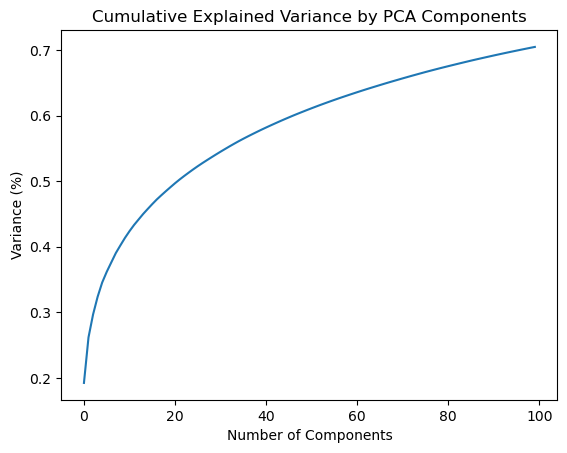

In [22]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

**Inference:**<br>
*-Each component contributes to explaining a certain amount of variance in the data, and the cumulative sum tells how much of the total variance is explained when considering multiple components.*<br>
*-The plot will show a curve that rises sharply and then levels off. The point where the curve starts to flatten out is known as the "elbow".This point indicates the number of components where adding more components yields minimal additional variance.*

**Prediction:**

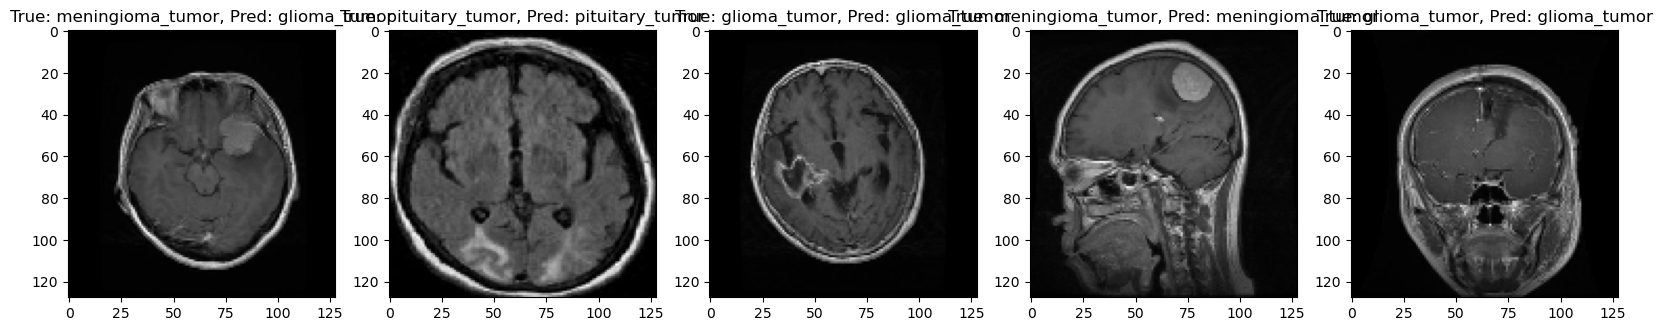

In [29]:
y_pred = svm.predict(X_test_pca)


fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i in range(5):
    ax[i].imshow(X_test[i], cmap='gray')
    ax[i].set_title(f'True: {tumor_types[y_test[i]]}, Pred: {tumor_types[y_pred[i]]}')
plt.show()

**Misclassification:**

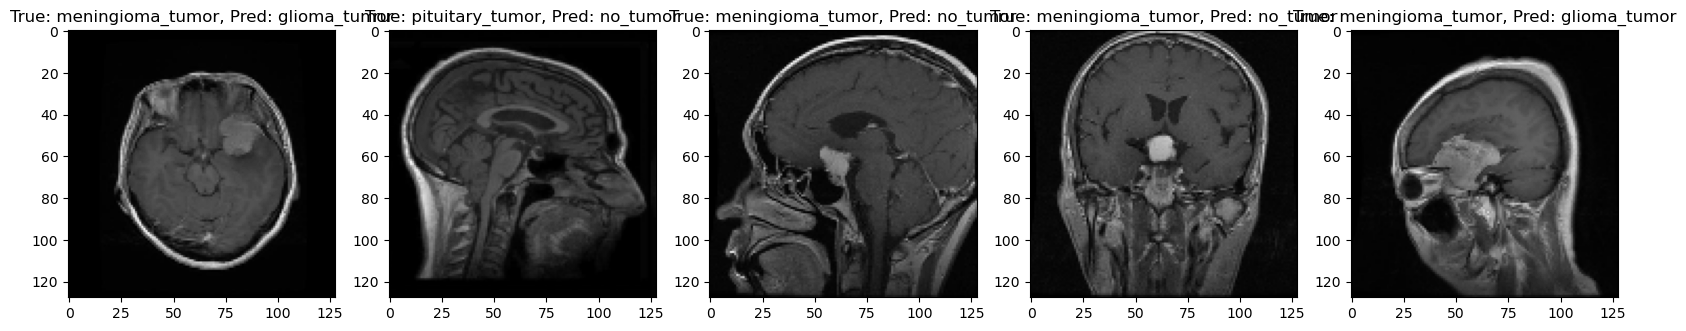

In [28]:
misclassified = np.where(y_test != y_pred)[0]
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for i, idx in enumerate(misclassified[:5]):
    ax[i].imshow(X_test[idx], cmap='gray')
    ax[i].set_title(f'True: {tumor_types[y_test[idx]]}, Pred: {tumor_types[y_pred[idx]]}')
plt.show()

In [26]:
misclassified

array([  0,   6,  20,  26,  39,  41,  42,  46,  48,  55,  59,  68,  72,
        75,  83,  84,  87,  89,  90,  91,  94,  96,  99, 111, 118, 127,
       155, 156, 160, 169, 171, 172, 173, 175, 176, 178, 190, 200, 205,
       207, 208, 209, 210, 212, 217, 218, 231, 232, 239, 240, 247, 248,
       262, 266, 267, 270, 286, 293, 297, 307, 309, 312, 314, 319, 320,
       321, 322, 324, 330, 342, 344, 350, 357, 358, 360, 362, 367, 371,
       373, 386, 387, 390, 394, 397, 399, 401, 402, 409, 410, 414, 417,
       429, 434, 443, 457, 466, 474, 502, 513, 514, 516, 521, 523, 530,
       537, 548, 549, 550, 555, 559, 562])

**Inference:**<br>
*-The visualizations collectively reveal the distribution and balance of tumor classes, the effectiveness of PCA in dimensionality reduction, and the performance of the SVM model.*<br>
*-The cumulative explained variance plot helps determine the number of PCA components to retain, while plots of confusion matrix, ROC curves, and feature importance provide insights into model accuracy and feature significance.*